### For all z500 identified anticyclones, pick those has timestamps in DJF, and duration >= 5 days, overlaid on DJF z500 climatology

### The tempest_extreme algo identifies $\Delta z500 = 10 m$ features within a 6 deg side length window, and tracks the evolution of the feature


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


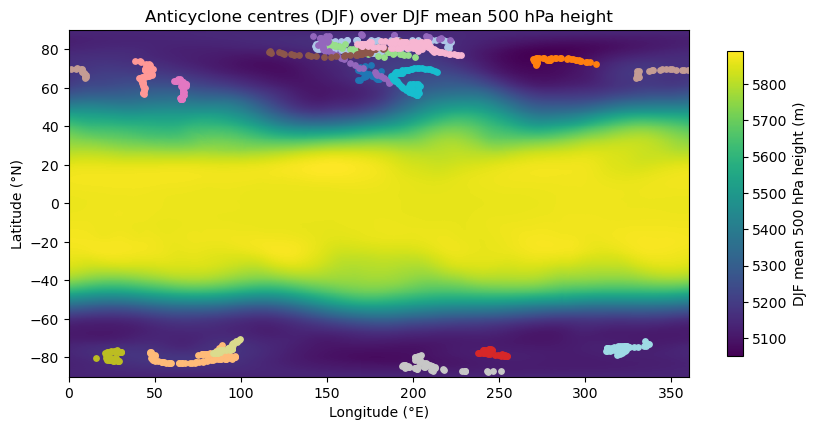

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Seasonal‐mean 500 hPa height for DJF with anticyclone centres.

  • Input track file  : reformatted_anticyclones_with_z500.csv
  • Input model field : ds['h_plev_coarse'] (will be opened here)
"""
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake,yaml,os
import intake_esm

# result of build_xshield_cat.ipynb
col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
col = intake.open_esm_datastore(col_url)
cat = col.search(variable_id = 'h_plev_coarse_C3072_1440x720')
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds = dset_dict['20191020.00Z.C3072.xs24v2.GLOBALFV3']

# ─── 1. paths & options ──────────────────────────────────────────────────────
TRACK_CSV    = '/scratch/cimes/xy4043/tracks/tracks_anticyc_3hrly/' \
               'reformatted_anticyclones_with_z500.csv'
PLEV_VAL     = 500.0    # hPa
MIN_STEPS    = 40       # ≥5 days at 3-hourly → 5×8=40
SEASON_MONTHS = [12, 1, 2]

# ─── 2. load & filter tracks ─────────────────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

# only keep track_ids with ≥ MIN_STEPS total
counts = df.groupby('track_id').size()
valid_ids = counts[counts >= MIN_STEPS].index
df = df[df['track_id'].isin(valid_ids)]

# only keep the DJF steps
df = df[df['time'].dt.month.isin(SEASON_MONTHS)]

# ─── 3. open & compute DJF seasonal mean ────────────────────────────────────
z500 = ds['h_plev_coarse'].sel(plev=PLEV_VAL)

# select only DJF months, then average over time
z500_djf = (
    z500
    .sel(time=z500['time'].dt.month.isin(SEASON_MONTHS))
    .mean('time')
)

# ─── 4. plot the seasonal mean & tracks ─────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4.5))

# background: DJF mean
lon = z500_djf['grid_xt_coarse']
lat = z500_djf['grid_yt_coarse']
Lon2d, Lat2d = np.meshgrid(lon, lat)
pc = ax.pcolormesh(Lon2d, Lat2d, z500_djf.values, shading='auto')
cb = fig.colorbar(pc, ax=ax, shrink=0.88)
cb.set_label('DJF mean 500 hPa height (m)')

# overlay each track in its own colour
track_ids = df['track_id'].unique()
cmap = get_cmap('tab20', len(track_ids))

for n, tid in enumerate(track_ids):
    sub = df[df['track_id'] == tid]
    nsteps = len(sub)
    ax.scatter(
        sub['lon'], sub['lat'],
        s=15, marker='o', color=cmap(n),
        label=f'track {tid} ({(nsteps/8):.1f} days)'
    )
    

# axes & legend
ax.set_xlim(0, 360)
ax.set_xlabel('Longitude (°E)')
ax.set_ylim(-90,  90)
ax.set_ylabel('Latitude (°N)')
ax.set_title('Anticyclone centres (DJF) over DJF mean 500 hPa height')
if len(track_ids) <= 12:
    ax.legend(
      bbox_to_anchor=(1.25,1), loc='upper left',
      frameon=False, fontsize=8
    )

# plt.tight_layout()
plt.show()


### Additional filter of 30-90 N, zonal advection distance <=30 deg


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


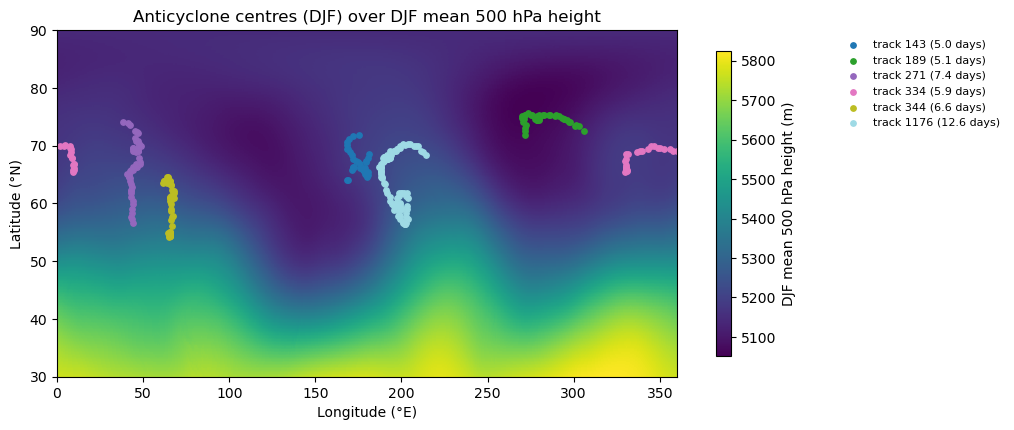

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
Seasonal‐mean 500 hPa height for DJF with anticyclone centres.

  • Input track file  : reformatted_anticyclones_with_z500.csv
  • Input model field : ds['h_plev_coarse'] (will be opened here)
"""
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake,yaml,os
import intake_esm

# result of build_xshield_cat.ipynb
col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
col = intake.open_esm_datastore(col_url)
cat = col.search(variable_id = 'h_plev_coarse_C3072_1440x720')
dset_dict = cat.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds = dset_dict['20191020.00Z.C3072.xs24v2.GLOBALFV3']

# ─── 1. paths & options ──────────────────────────────────────────────────────
TRACK_CSV    = '/scratch/cimes/xy4043/tracks/tracks_anticyc_3hrly/' \
               'reformatted_anticyclones_with_z500.csv'
PLEV_VAL     = 500.0    # hPa
MIN_STEPS    = 40       # ≥5 days at 3-hourly → 5×8=40
SEASON_MONTHS = [12, 1, 2]
LAT_RANGE     = (30, 90) # only 30–90° N
MAX_LON_SPAN  = 40       # degrees

# ─── 2. load & filter tracks ─────────────────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

# only keep track_ids with ≥ MIN_STEPS total
counts = df.groupby('track_id').size()
valid_ids = counts[counts >= MIN_STEPS].index
df = df[df['track_id'].isin(valid_ids)]

# only keep the DJF steps
df = df[df['time'].dt.month.isin(SEASON_MONTHS)]

# only keep points between 30° N and 90° N
df = df[(df['lat'] >= LAT_RANGE[0]) & (df['lat'] <= LAT_RANGE[1])]

# filter out any tracks whose longitudinal span > MAX_LON_SPAN (handling wrap)
def lon_span(lons):
    raw = lons.max() - lons.min()
    wrap = (lons.min() + 360) - lons.max()
    return min(raw, wrap)

good_tracks = []
for tid, sub in df.groupby('track_id'):
    if lon_span(sub['lon'].values) <= MAX_LON_SPAN:
        good_tracks.append(tid)

df = df[df['track_id'].isin(good_tracks)]
track_ids = df['track_id'].unique()

# ─── 3. open & compute DJF seasonal mean ────────────────────────────────────
z500 = ds['h_plev_coarse'].sel(plev=PLEV_VAL)

# select only DJF months, then average over time
z500_djf = (
    z500
    .sel(time=z500['time'].dt.month.isin(SEASON_MONTHS))
    .sel(grid_yt_coarse=slice(LAT_RANGE[0], LAT_RANGE[1]))
    .mean('time')
)

# ─── 4. plot the seasonal mean & tracks ─────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 4.5))

# background: DJF mean
lon = z500_djf['grid_xt_coarse']
lat = z500_djf['grid_yt_coarse']
Lon2d, Lat2d = np.meshgrid(lon, lat)
pc = ax.pcolormesh(Lon2d, Lat2d, z500_djf.values, shading='auto')
cb = fig.colorbar(pc, ax=ax, shrink=0.88)
cb.set_label('DJF mean 500 hPa height (m)')

# overlay each track in its own colour
cmap = get_cmap('tab20', len(track_ids))

for n, tid in enumerate(track_ids):
    sub = df[df['track_id'] == tid]
    nsteps = len(sub)
    ax.scatter(
        sub['lon'], sub['lat'],
        s=15, marker='o', color=cmap(n),
        label=f'track {tid} ({(nsteps/8):.1f} days)'
    )
    

# axes & legend
ax.set_xlim(0, 360)
ax.set_xlabel('Longitude (°E)')
ax.set_ylim(LAT_RANGE)
ax.set_ylabel('Latitude (°N)')
ax.set_title('Anticyclone centres (DJF) over DJF mean 500 hPa height')

if len(track_ids) <= 12:
    ax.legend(
      bbox_to_anchor=(1.25,1), loc='upper left',
      frameon=False, fontsize=8
    )

# plt.tight_layout()
plt.show()


### pick out track 1176, the most persistent one (blocking)

In [4]:
tid = 1176
sub1176 = df[df['track_id'] == tid]

sub1176


,track_id,year,month,day,hour,i,j,lon,lat,z500,time
11849,1176,2020,12,21,18,795,591,198.875,57.875,5708.769,2020-12-21 18:00:00
11850,1176,2020,12,21,21,793,592,198.375,58.125,5718.020,2020-12-21 21:00:00
11851,1176,2020,12,22,0,792,598,198.125,59.625,5716.452,2020-12-22 00:00:00
11852,1176,2020,12,22,3,800,596,200.125,59.125,5715.899,2020-12-22 03:00:00
11853,1176,2020,12,22,6,797,600,199.375,60.125,5719.671,2020-12-22 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...
11945,1176,2021,1,2,18,833,639,208.375,69.875,5448.520,2021-01-02 18:00:00
11946,1176,2021,1,2,21,838,639,209.625,69.875,5447.336,2021-01-02 21:00:00
11947,1176,2021,1,3,0,844,636,211.125,69.125,5445.408,2021-01-03 00:00:00
11948,1176,2021,1,3,3,850,635,212.625,68.875,5439.908,2021-01-03 03:00:00


In [11]:
z500

<xarray.DataArray 'h_plev_coarse' (time: 3560, grid_yt_coarse: 720,
                                   grid_xt_coarse: 1440)> Size: 15GB
dask.array<getitem, shape=(3560, 720, 1440), dtype=float32, chunksize=(5, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) object 28kB 2019-10-20 03:00:00 ... 2021-01-07 00:...
    plev            float32 4B 500.0
  * grid_yt_coarse  (grid_yt_coarse) float32 3kB -89.88 -89.62 ... 89.62 89.88
  * grid_xt_coarse  (grid_xt_coarse) float32 6kB 0.125 0.375 ... 359.6 359.9
    h_plev_coarse   (time, grid_yt_coarse, grid_xt_coarse) float32 15GB dask.array<chunksize=(5, 180, 360), meta=np.ndarray>
Attributes:
    units:          m
    long_name:      coarse-grained height
    cell_methods:   time: point
    interp_method:  conserve_order1

### Onset, Peak, Decay of the event


Selected timestamps (Gregorian → Julian calendar):
  onset: 2020-12-21 18:00:00  →  2020-12-21 18:00:00
   peak: 2020-12-25 12:00:00  →  2020-12-25 12:00:00
  decay: 2021-01-03 06:00:00  →  2021-01-03 06:00:00


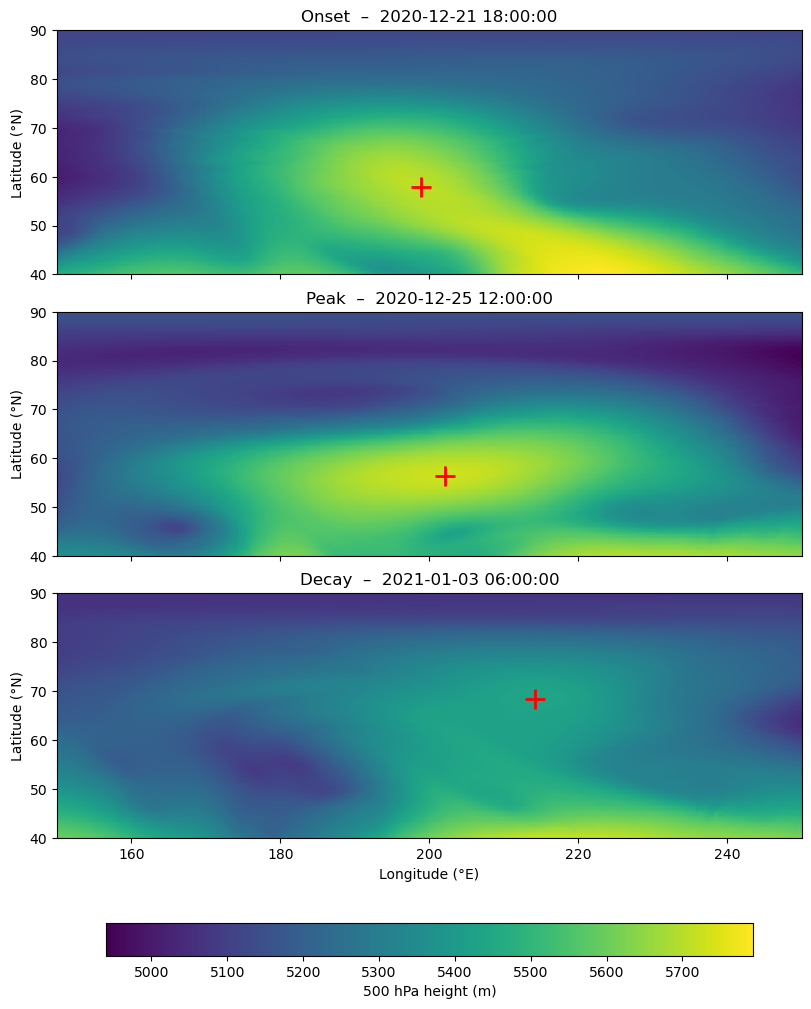

In [16]:
# ─── extra imports ──────────────────────────────────────────────────────────
import cftime
from matplotlib.dates import DateFormatter

# ─── 1. narrow to the single track & map window ─────────────────────────────
TRACK_ID        = 1176
REGION_LAT      = (40, 90)          # 40–90 ° N
REGION_LON      = (150, 250)        # 150–250 ° E (0–360 convention)

# keep only the desired track and map window
sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')                         # ensure chronological
      .query('lat.between(@REGION_LAT[0], @REGION_LAT[1]) '
             'and lon.between(@REGION_LON[0], @REGION_LON[1])')
      .reset_index(drop=True)
)

if sub.empty:
    raise ValueError('No points from track 1176 fall in the requested window.')

# ─── 2. pick onset / peak / decay timestamps ────────────────────────────────
onset_time  = sub.loc[0,  'time']
decay_time  = sub.loc[len(sub)-1, 'time']
peak_row    = sub['z500'].idxmax()
peak_time   = sub.loc[peak_row, 'time']

def to_julian(ts: pd.Timestamp) -> cftime.DatetimeJulian:
    """Convert pandas.Timestamp → cftime.DatetimeJulian (no year 0)."""
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_julian(v.to_pydatetime()) for k, v in times_pd.items()}

print('\nSelected timestamps (Gregorian → Julian calendar):')
for k in ('onset', 'peak', 'decay'):
    print(f'  {k:>5}: {times_pd[k]}  →  {times_cf[k]}')

# ─── 3. slice the z500 cube just once per stage (lazy dask) ─────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
z500_snaps = {
    stage: (
        z500_full
        .sel(time=cf_time, method='nearest')
        .sel(grid_yt_coarse=slice(*REGION_LAT),
             grid_xt_coarse=slice(*REGION_LON))
        .load()                                     # small; safe to load
    )
    for stage, cf_time in times_cf.items()
}

# ─── 4. plotting ────────────────────────────────────────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 10), sharex=True, sharey=True,
    constrained_layout=True
)
stages = ('onset', 'peak', 'decay')
cmap   = 'viridis'
vmin   = min(s.min().item() for s in z500_snaps.values())
vmax   = max(s.max().item() for s in z500_snaps.values())

for ax, stage in zip(axs, stages):
    snap = z500_snaps[stage]
    lon  = snap['grid_xt_coarse']; lat = snap['grid_yt_coarse']
    Lon2d, Lat2d = np.meshgrid(lon, lat)

    pc = ax.pcolormesh(Lon2d, Lat2d, snap.values,
                       shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    # red “×” at the track position for this stage
    row = sub.loc[sub['time'] == times_pd[stage]].iloc[0]
    ax.plot(row['lon'], row['lat'], 'r+', markersize=14, mew=2)

    ax.set_title(f"{stage.capitalize()}  –  {times_pd[stage]}")
    ax.set_ylabel('Latitude (°N)')
    ax.set_xlim(REGION_LON); ax.set_ylim(REGION_LAT)

# tidy x-axis and single colour-bar
axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(pc, ax=axs, orientation='horizontal', fraction=0.04,
             pad=0.05, label='500 hPa height (m)')
plt.show()



Selected timestamps (Gregorian → Julian calendar):
  onset: 2020-12-21 18:00:00  →  2020-12-21 18:00:00
   peak: 2020-12-25 12:00:00  →  2020-12-25 12:00:00
  decay: 2021-01-03 06:00:00  →  2021-01-03 06:00:00


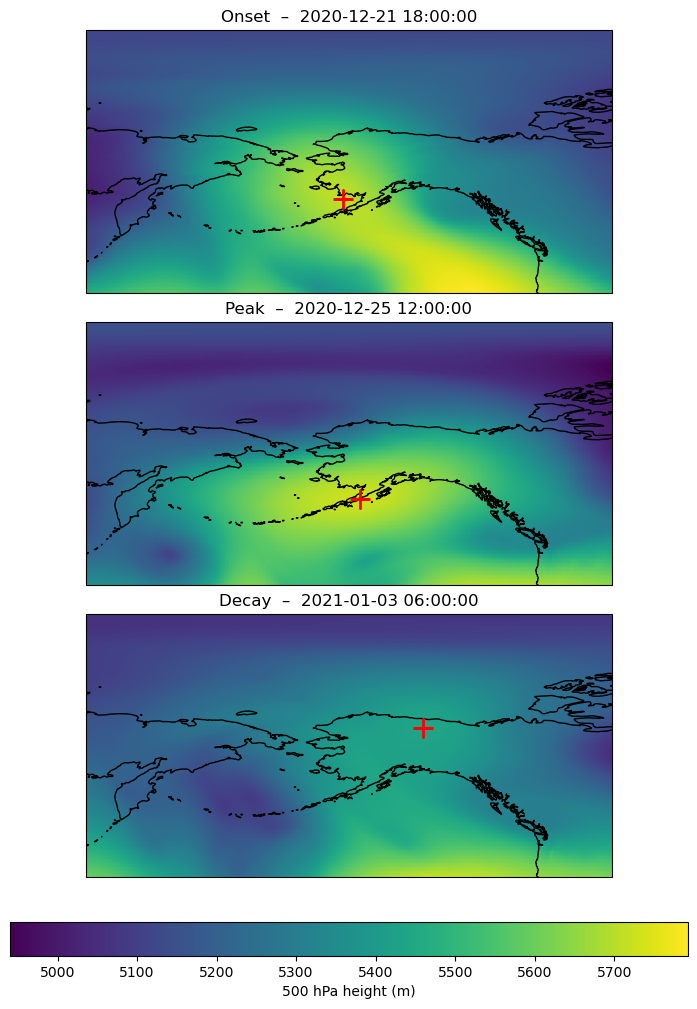

In [3]:
# ─── extra imports ──────────────────────────────────────────────────────────
import cftime
from matplotlib.dates import DateFormatter
import cartopy.crs as ccrs

# ─── 1. narrow to the single track & map window ─────────────────────────────
TRACK_ID        = 1176
REGION_LAT      = (40, 90)          # 40–90 ° N
REGION_LON      = (150, 250)        # 150–250 ° E (0–360 convention)

# keep only the desired track and map window
sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')                         # ensure chronological
      .query('lat.between(@REGION_LAT[0], @REGION_LAT[1]) '
             'and lon.between(@REGION_LON[0], @REGION_LON[1])')
      .reset_index(drop=True)
)

if sub.empty:
    raise ValueError('No points from track 1176 fall in the requested window.')

# ─── 2. pick onset / peak / decay timestamps ────────────────────────────────
onset_time  = sub.loc[0,  'time']
decay_time  = sub.loc[len(sub)-1, 'time']
peak_row    = sub['z500'].idxmax()
peak_time   = sub.loc[peak_row, 'time']

def to_julian(ts: pd.Timestamp) -> cftime.DatetimeJulian:
    """Convert pandas.Timestamp → cftime.DatetimeJulian (no year 0)."""
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_julian(v.to_pydatetime()) for k, v in times_pd.items()}

print('\nSelected timestamps (Gregorian → Julian calendar):')
for k in ('onset', 'peak', 'decay'):
    print(f'  {k:>5}: {times_pd[k]}  →  {times_cf[k]}')

# ─── 3. slice the z500 cube just once per stage (lazy dask) ─────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
z500_snaps = {
    stage: (
        z500_full
        .sel(time=cf_time)
        .sel(grid_yt_coarse=slice(*REGION_LAT),
             grid_xt_coarse=slice(*REGION_LON))
        .load()                                     # small; safe to load
    )
    for stage, cf_time in times_cf.items()
}

# ─── 4. plotting with a 180°-centered PlateCarree ─────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 10), sharex=True, sharey=True,
    constrained_layout=True,
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}
)
stages = ('onset', 'peak', 'decay')
cmap   = 'viridis'
vmin   = min(s.min().item() for s in z500_snaps.values())
vmax   = max(s.max().item() for s in z500_snaps.values())

for ax, stage in zip(axs, stages):
    snap = z500_snaps[stage]
    lon  = snap['grid_xt_coarse']
    lat  = snap['grid_yt_coarse']
    Lon2d, Lat2d = np.meshgrid(lon, lat)

    # now 150–250° E will straddle the central meridian (180°)
    pc = ax.pcolormesh(
        Lon2d, Lat2d, snap.values,
        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    # red “×” at the track position for this stage
    row = sub.loc[sub['time'] == times_pd[stage]].iloc[0]
    ax.plot(
        row['lon'], row['lat'], 'r+', markersize=14, mew=2,
        transform=ccrs.PlateCarree()
    )

    ax.coastlines()

    # **explicitly constrain to 150–250 E, 40–90 N in the 0–360 system**
    ax.set_extent(
        [REGION_LON[0], REGION_LON[1],
         REGION_LAT[0], REGION_LAT[1]],
        crs=ccrs.PlateCarree()
    )

    ax.set_title(f"{stage.capitalize()}  –  {times_pd[stage]}")
    ax.set_ylabel('Latitude (°N)')

# tidy x-axis label and single horizontal colourbar
axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(
    pc, ax=axs, orientation='horizontal',
    fraction=0.04, pad=0.05,
    label='500 hPa height (m)'
)
plt.show()



### Show the thermocontributions
Thermodynamic Eqn from ECMWF is 
$$
\dot{T} = \frac{\partial T}{\partial t}+\frac{1}{a \cos ^2 \theta}\left\{U \frac{\partial T}{\partial \lambda}+V \cos \theta \frac{\partial T}{\partial \theta}\right\}+\dot{\eta} \frac{\partial T}{\partial \eta}-\frac{\kappa T_{\mathrm{v}} \omega}{(1+(\delta-1) q) p}=P_T+K_T
$$

$P_T$ is tendency from parametrized physical processes, and $K_T$ is numerical diffusion (small error)

From xsh24, the tendency terms are t_dt_gfdlmp + t_dt_phys

From Tamarin \& Kapsi (2016), 
$$
\frac{D q}{D t} = Q+F \approx Q=-g\left(f \mathbf{k}+\nabla_p \times \mathbf{u}\right) \cdot \nabla_p\left(\frac{D \theta}{D t}\right)
$$
i.e.,

$$
\frac{D q}{D t} \approx -g\left(\frac{p_s}{p}\right)^{\frac{R}{c_p}}\left[\left(\frac{\partial w}{\partial y}-\frac{\partial v}{\partial p}\right) \frac{\partial \dot{T}}{\partial x}+\left(\frac{\partial u}{\partial p}-\frac{\partial w}{\partial x}\right) \frac{\partial \dot{T}}{\partial y}+\left(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}+f\right) \frac{\partial \dot{T}}{\partial p}\right]
$$

### t_dt_phys and t_dt_gfdlmp

In [5]:
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake,yaml,os
import intake_esm

# result of build_xshield_cat.ipynb
col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
col = intake.open_esm_datastore(col_url)

cat_t_dt_phys = col.search(variable_id = 't_dt_phys_coarse_C3072_1440x720')
dset_dict_t_dt_phys = cat_t_dt_phys.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds_t_dt_phys = dset_dict_t_dt_phys['20191020.00Z.C3072.xs24v2.GLOBALFV3']


cat_t_dt_gfdlmp = col.search(variable_id = 't_dt_gfdlmp_coarse_C3072_1440x720')
dset_dict_t_dt_gfdlmp = cat_t_dt_gfdlmp.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds_t_dt_gfdlmp = dset_dict_t_dt_gfdlmp['20191020.00Z.C3072.xs24v2.GLOBALFV3']


cat_t_dt_shallow_convection = col.search(variable_id = 'tendency_of_air_temperature_due_to_shallow_convection_coarse_C3072_1440x720')
dset_dict_t_dt_shallow_convection = cat_t_dt_shallow_convection.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds_t_dt_shallow_convection = dset_dict_t_dt_shallow_convection['20191020.00Z.C3072.xs24v2.GLOBALFV3']



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


### Function to interp _dt terms

In [37]:
import cftime
import xarray as xr
import matplotlib.pyplot as plt

def interp_and_plot_time(
    da: xr.DataArray,
    target_time: cftime.DatetimeJulian,
    lev: float,
    figsize=(8,4)
) -> xr.DataArray:
    """
    Time-interpolate a DataArray at level `lev` to `target_time` by averaging
    the two nearest time slices. Prints bracketing times, plots the result,
    and returns the interpolated DataArray.

    Parameters
    ----------
    da : xr.DataArray
        must have dims including 'time' and 'pfull'
    target_time : cftime.DatetimeJulian
        the desired timestamp to interpolate to
    lev : float
        nominal pressure level (hPa) to select via `method='nearest'`
    figsize : tuple
        figure size for the plot

    Returns
    -------
    da_avg : xr.DataArray
        the time-interpolated slice at `target_time`
    """
    # select nearest level, but record the actual pfull value
    da_lvl    = da.sel(pfull=lev, method='nearest')
    true_plev = float(da_lvl['pfull'].item())

    # find bracketing times
    times      = da_lvl['time']
    t_before   = times.where(times <= target_time, drop=True).max().item()
    t_after    = times.where(times >= target_time, drop=True).min().item()
    print(f"bracketing times: {t_before}  →  {t_after}")

    # average the two slices
    da_b       = da_lvl.sel(time=t_before)
    da_a       = da_lvl.sel(time=t_after)
    da_avg     = 0.5*(da_b + da_a)

    # plot
    fig, ax = plt.subplots(figsize=figsize)
    da_avg.plot(ax=ax)
    varname = da_avg.name or "variable"
    ax.set_title(
        f"{varname} at {true_plev:.1f} hPa interpolated to\n{target_time}"
    )
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude')
    plt.show()

    return da_avg


bracketing times: 2020-12-21 16:30:00  →  2020-12-21 19:30:00


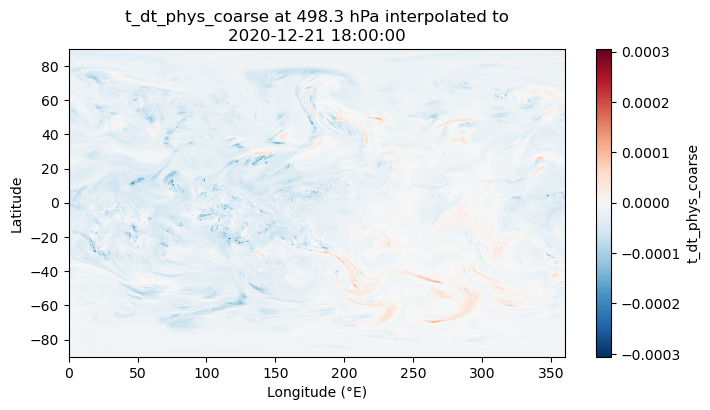

In [42]:
from cftime import DatetimeJulian

# build onset time
t0 = DatetimeJulian(2020, 12, 21, 18, 0, 0, has_year_zero=False)

# call the function on your DataArray
da_interp_onset_phys = interp_and_plot_time(
    ds_t_dt_phys.t_dt_phys_coarse,
    target_time=t0,
    lev=500.0
)



bracketing times: 2020-12-21 16:30:00  →  2020-12-21 19:30:00


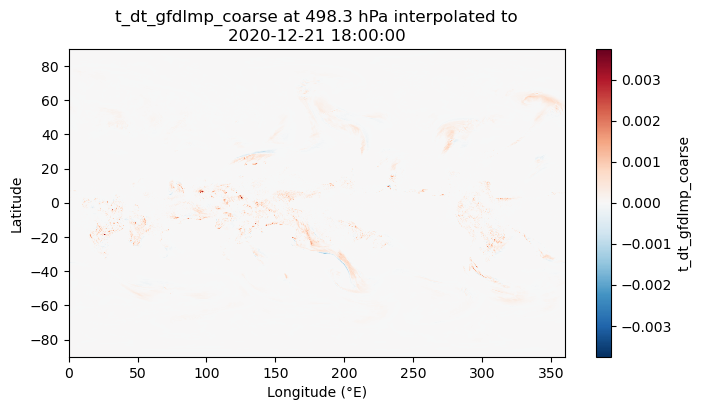

In [40]:
# call the function on your DataArray
da_interp_onset_gfdlmp = interp_and_plot_time(
    ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse,
    target_time=t0,
    lev=500.0
)

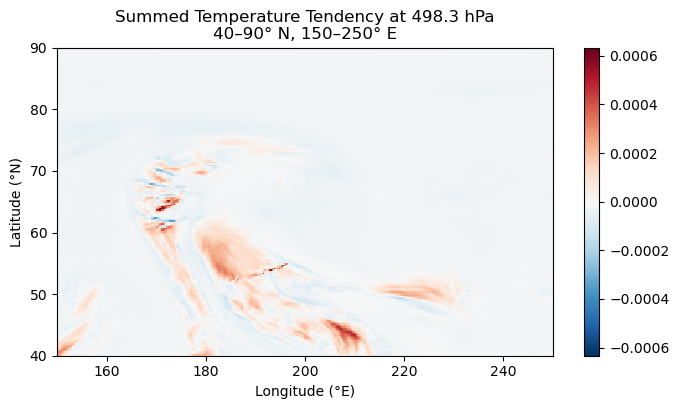

In [47]:
# define your box
lat_slice = slice(40, 90)    # 40–90° N
lon_slice = slice(150, 250)  # 150–250° E (0–360° convention)

# grab the region from each
phys = da_interp_onset_phys.sel(
    grid_yt_coarse=lat_slice,
    grid_xt_coarse=lon_slice
)
gfdl = da_interp_onset_gfdlmp.sel(
    grid_yt_coarse=lat_slice,
    grid_xt_coarse=lon_slice
)

# sum and plot
region_sum = phys + gfdl

fig, ax = plt.subplots(figsize=(8,4))
region_sum.plot(ax=ax)
ax.set_title(
    f"Summed Temperature Tendency at {phys.pfull.values:.1f} hPa\n"
    "40–90° N, 150–250° E"
)
ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Latitude (°N)')
plt.show()


#### A self-contained code to extrat onset, peak, decay temp tendency after loading  ds['h_plev_coarse'], ds_t_dt_phys, and ds_t_dt_gfdlmp


Selected Gregorian → Julian:
onset: 2020-12-21 18:00:00  →  2020-12-21 18:00:00
 peak: 2020-12-25 12:00:00  →  2020-12-25 12:00:00
decay: 2021-01-03 06:00:00  →  2021-01-03 06:00:00
onset  bracketing: 2020-12-21 16:30:00 → 2020-12-21 19:30:00  (pfull=498.3 hPa)
 peak  bracketing: 2020-12-25 10:30:00 → 2020-12-25 13:30:00  (pfull=498.3 hPa)
decay  bracketing: 2021-01-03 04:30:00 → 2021-01-03 07:30:00  (pfull=498.3 hPa)


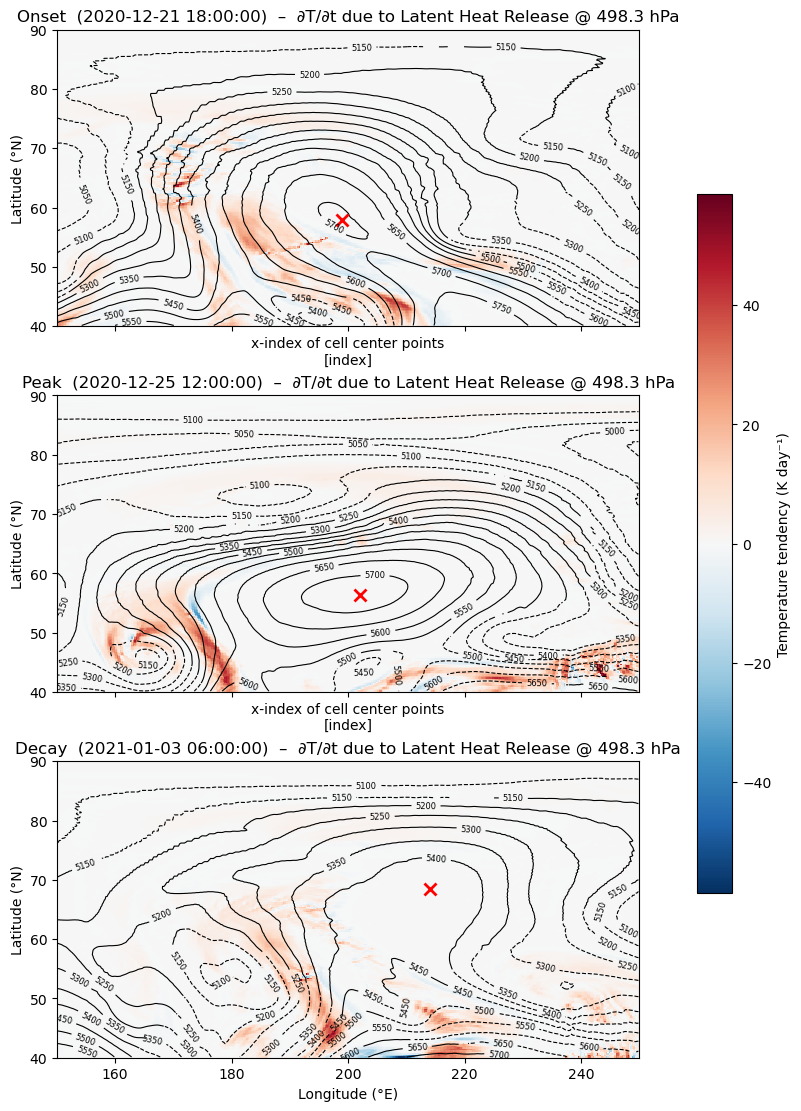

CPU times: user 15.6 s, sys: 2.94 s, total: 18.5 s
Wall time: 18.1 s


In [17]:
%%time
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import matplotlib.pyplot as plt

# ── 0. handy helper ─────────────────────────────────────────────────────────
def interp_slice(da, target, lev):
    """
    Average the two nearest time slices of `da` (time, pfull, y, x)
    to `target` (cftime) at the *nearest* pressure level `lev`.
    Returns (slice, true_pfull, t_before, t_after).
    """
    da_lvl    = da.sel(pfull=lev, method='nearest')
    true_lev  = float(da_lvl.pfull.item())

    times   = da_lvl.time
    t_bef   = times.where(times<=target, drop=True).max().item()
    t_aft   = times.where(times>=target, drop=True).min().item()

    slice_  = 0.5*(da_lvl.sel(time=t_bef) + da_lvl.sel(time=t_aft))
    return slice_, true_lev, t_bef, t_aft

# ── 1. parameters & region box ──────────────────────────────────────────────
TRACK_ID   = 1176
LAT_SLICE  = slice(40, 90)      # 40–90 ° N
LON_SLICE  = slice(150, 250)    # 150–250 ° E
LEV        = 500.0              # nominal hPa

# ── 2. track dataframe (already on disk) ────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df   = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')
      .query('lat.between(@LAT_SLICE.start, @LAT_SLICE.stop) '
             'and lon.between(@LON_SLICE.start, @LON_SLICE.stop)')
      .reset_index(drop=True)
)
if sub.empty:
    raise ValueError('Track 1176 has no points in the requested window.')

onset_time = sub.time.iloc[0]
decay_time = sub.time.iloc[-1]
peak_time  = sub.loc[sub['z500'].idxmax(), 'time']

def to_jul(ts: pd.Timestamp):
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_jul(v) for k, v in times_pd.items()}

print('\nSelected Gregorian → Julian:')
for k in times_pd:
    print(f"{k:>5}: {times_pd[k]}  →  {times_cf[k]}")



# ── 2.5. get lon/lat for each stage ─────────────────────────────────────────
coords = {
    'onset': (sub.loc[sub.time == onset_time, 'lon'].values[0],
              sub.loc[sub.time == onset_time, 'lat'].values[0]),
    'peak' : (sub.loc[sub.time == peak_time,  'lon'].values[0],
              sub.loc[sub.time == peak_time,  'lat'].values[0]),
    'decay': (sub.loc[sub.time == decay_time, 'lon'].values[0],
              sub.loc[sub.time == decay_time, 'lat'].values[0]),
}

# ── 3. DJF climatology of z500 (for contour styling) ────────────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
clim      = (
    z500_full
    .where(z500_full['time'].dt.season=='DJF', drop=True)
    .mean('time')
    .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
    .load()
)

# ── 4. build snapshots for each stage ───────────────────────────────────────
snaps = {}
for stage, t_cf in times_cf.items():
    # ─ temperature-tendency sum
    shallow_convection, p_lev, t_b, t_a = interp_slice(
        ds_t_dt_shallow_convection.tendency_of_air_temperature_due_to_shallow_convection_coarse, t_cf, LEV
    )
    gfdl, _,     _,   _   = interp_slice(
        ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse, t_cf, LEV
    )
    tend = (86400*(shallow_convection + gfdl)).sel(
        grid_yt_coarse=LAT_SLICE,
        grid_xt_coarse=LON_SLICE
    ).load()

    # ─ matching z500
    z500 = (
        z500_full
        .sel(time=t_cf, method='nearest')
        .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
        .load()
    )

    snaps[stage] = dict(tend=tend, z500=z500, true_lev=p_lev)

    print(f"{stage:>5}  bracketing: {t_b} → {t_a}  (pfull={p_lev:.1f} hPa)")

# ── 5. common colour scale for filled contours ──────────────────────────────
raw_min = min(s['tend'].min().item() for s in snaps.values())
raw_max = max(s['tend'].max().item() for s in snaps.values())

# centre at 0 and cap at 95 % of the smaller absolute extreme
halfspan = 0.95 * min(abs(raw_min), abs(raw_max))
vmin, vmax = -halfspan, halfspan

# ── 6. plotting ─────────────────────────────────────────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 11), sharex=True, sharey=True,
    constrained_layout=True
)
stages = ('onset', 'peak', 'decay')

for ax, st in zip(axs, stages):
    tend = snaps[st]['tend']
    z    = snaps[st]['z500']
    lev  = snaps[st]['true_lev']

    # filled field: summed tendency
    pcm = tend.plot.pcolormesh(
        ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
    )

    # mask by sign relative to climatology
    pos = z.where(z > clim)
    neg = z.where(z < clim)

    # choose sensible contour interval (50 m)
    base = 50 * round(z.mean().item()/50)
    levs = np.arange(base-400, base+401, 50)

    # solid where > climatology
    if not np.isnan(pos).all():
        cs_pos = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], pos,
            levels=levs, colors='k', linewidths=0.8, linestyles='solid'
        )
        ax.clabel(cs_pos, fmt='%d', inline=True, fontsize=6)

    # dashed where < climatology
    if not np.isnan(neg).all():
        cs_neg = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], neg,
            levels=levs, colors='k', linewidths=0.8, linestyles='dashed'
        )
        ax.clabel(cs_neg, fmt='%d', inline=True, fontsize=6)


    # add a red “×” at the track location for this stage
    lon_pt, lat_pt = coords[st]
    ax.plot(lon_pt, lat_pt,
            marker='x', color='red', markersize=8, markeredgewidth=2)

    ax.set_title(f"{st.capitalize()}  ({times_pd[st]})  –  ∂T/∂t due to Latent Heat Release @ {lev:.1f} hPa")
    ax.set_ylabel('Latitude (°N)')
    # ax.set_xlim(LON_SLICE.start, LON_SLICE.stop)
    ax.set_ylim(LAT_SLICE.start, LAT_SLICE.stop)

axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=0.06,
             pad=0.1, label='Temperature tendency (K day⁻¹)')

plt.show()


In [ ]:
%%time
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import matplotlib.pyplot as plt

# ── 0. handy helper ─────────────────────────────────────────────────────────
def interp_slice(da, target, lev):
    """
    Average the two nearest time slices of `da` (time, pfull, y, x)
    to `target` (cftime) at the *nearest* pressure level `lev`.
    Returns (slice, true_pfull, t_before, t_after).
    """
    da_lvl    = da.sel(pfull=lev, method='nearest')
    true_lev  = float(da_lvl.pfull.item())

    times   = da_lvl.time
    t_bef   = times.where(times<=target, drop=True).max().item()
    t_aft   = times.where(times>=target, drop=True).min().item()

    slice_  = 0.5*(da_lvl.sel(time=t_bef) + da_lvl.sel(time=t_aft))
    return slice_, true_lev, t_bef, t_aft

# ── 1. parameters & region box ──────────────────────────────────────────────
TRACK_ID   = 1176
LAT_SLICE  = slice(40, 90)      # 40–90 ° N
LON_SLICE  = slice(150, 250)    # 150–250 ° E
LEV        = 500.0              # nominal hPa

# ── 2. track dataframe (already on disk) ────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df   = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')
      .query('lat.between(@LAT_SLICE.start, @LAT_SLICE.stop) '
             'and lon.between(@LON_SLICE.start, @LON_SLICE.stop)')
      .reset_index(drop=True)
)
if sub.empty:
    raise ValueError('Track 1176 has no points in the requested window.')

onset_time = sub.time.iloc[0]
decay_time = sub.time.iloc[-1]
peak_time  = sub.loc[sub['z500'].idxmax(), 'time']

def to_jul(ts: pd.Timestamp):
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_jul(v) for k, v in times_pd.items()}

print('\nSelected Gregorian → Julian:')
for k in times_pd:
    print(f"{k:>5}: {times_pd[k]}  →  {times_cf[k]}")



# ── 2.5. get lon/lat for each stage ─────────────────────────────────────────
coords = {
    'onset': (sub.loc[sub.time == onset_time, 'lon'].values[0],
              sub.loc[sub.time == onset_time, 'lat'].values[0]),
    'peak' : (sub.loc[sub.time == peak_time,  'lon'].values[0],
              sub.loc[sub.time == peak_time,  'lat'].values[0]),
    'decay': (sub.loc[sub.time == decay_time, 'lon'].values[0],
              sub.loc[sub.time == decay_time, 'lat'].values[0]),
}

# ── 3. DJF climatology of z500 (for contour styling) ────────────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
clim      = (
    z500_full
    .where(z500_full['time'].dt.season=='DJF', drop=True)
    .mean('time')
    .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
    .load()
)

# ── 4. build snapshots for each stage ───────────────────────────────────────
snaps = {}
for stage, t_cf in times_cf.items():
    # ─ temperature-tendency sum
    shallow_convection, p_lev, t_b, t_a = interp_slice(
        ds_t_dt_shallow_convection.tendency_of_air_temperature_due_to_shallow_convection_coarse, t_cf, LEV
    )
    gfdl, _,     _,   _   = interp_slice(
        ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse, t_cf, LEV
    )
    tend = (86400*(shallow_convection + gfdl)).sel(
        grid_yt_coarse=LAT_SLICE,
        grid_xt_coarse=LON_SLICE
    ).load()

    # ─ matching z500
    z500 = (
        z500_full
        .sel(time=t_cf, method='nearest')
        .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
        .load()
    )

    snaps[stage] = dict(tend=tend, z500=z500, true_lev=p_lev)

    print(f"{stage:>5}  bracketing: {t_b} → {t_a}  (pfull={p_lev:.1f} hPa)")

# ── 5. common colour scale for filled contours ──────────────────────────────
raw_min = min(s['tend'].min().item() for s in snaps.values())
raw_max = max(s['tend'].max().item() for s in snaps.values())

# centre at 0 and cap at 95 % of the smaller absolute extreme
halfspan = 0.95 * min(abs(raw_min), abs(raw_max))
vmin, vmax = -halfspan, halfspan

# ── 6. plotting ─────────────────────────────────────────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 11), sharex=True, sharey=True,
    constrained_layout=True
)
stages = ('onset', 'peak', 'decay')

for ax, st in zip(axs, stages):
    tend = snaps[st]['tend']
    z    = snaps[st]['z500']
    lev  = snaps[st]['true_lev']

    # filled field: summed tendency
    pcm = tend.plot.pcolormesh(
        ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
    )

    # mask by sign relative to climatology
    pos = z.where(z > clim)
    neg = z.where(z < clim)

    # choose sensible contour interval (50 m)
    base = 50 * round(z.mean().item()/50)
    levs = np.arange(base-400, base+401, 50)

    # solid where > climatology
    if not np.isnan(pos).all():
        cs_pos = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], pos,
            levels=levs, colors='k', linewidths=0.8, linestyles='solid'
        )
        ax.clabel(cs_pos, fmt='%d', inline=True, fontsize=6)

    # dashed where < climatology
    if not np.isnan(neg).all():
        cs_neg = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], neg,
            levels=levs, colors='k', linewidths=0.8, linestyles='dashed'
        )
        ax.clabel(cs_neg, fmt='%d', inline=True, fontsize=6)


    # add a red “×” at the track location for this stage
    lon_pt, lat_pt = coords[st]
    ax.plot(lon_pt, lat_pt,
            marker='x', color='red', markersize=8, markeredgewidth=2)

    ax.set_title(f"{st.capitalize()}  ({times_pd[st]})  –  ∂T/∂t due to Latent Heat Release @ {lev:.1f} hPa")
    ax.set_ylabel('Latitude (°N)')
    # ax.set_xlim(LON_SLICE.start, LON_SLICE.stop)
    ax.set_ylim(LAT_SLICE.start, LAT_SLICE.stop)

axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=0.06,
             pad=0.1, label='Temperature tendency (K day⁻¹)')

plt.show()


### Upper level 250hPa - still needs t_dt_sg, which is the tropopause correction of numerical diffusion


Selected Gregorian → Julian:
onset: 2020-12-21 18:00:00  →  2020-12-21 18:00:00
 peak: 2020-12-25 12:00:00  →  2020-12-25 12:00:00
decay: 2021-01-03 06:00:00  →  2021-01-03 06:00:00
onset  bracketing: 2020-12-21 16:30:00 → 2020-12-21 19:30:00  (pfull=253.4 hPa)
 peak  bracketing: 2020-12-25 10:30:00 → 2020-12-25 13:30:00  (pfull=253.4 hPa)
decay  bracketing: 2021-01-03 04:30:00 → 2021-01-03 07:30:00  (pfull=253.4 hPa)


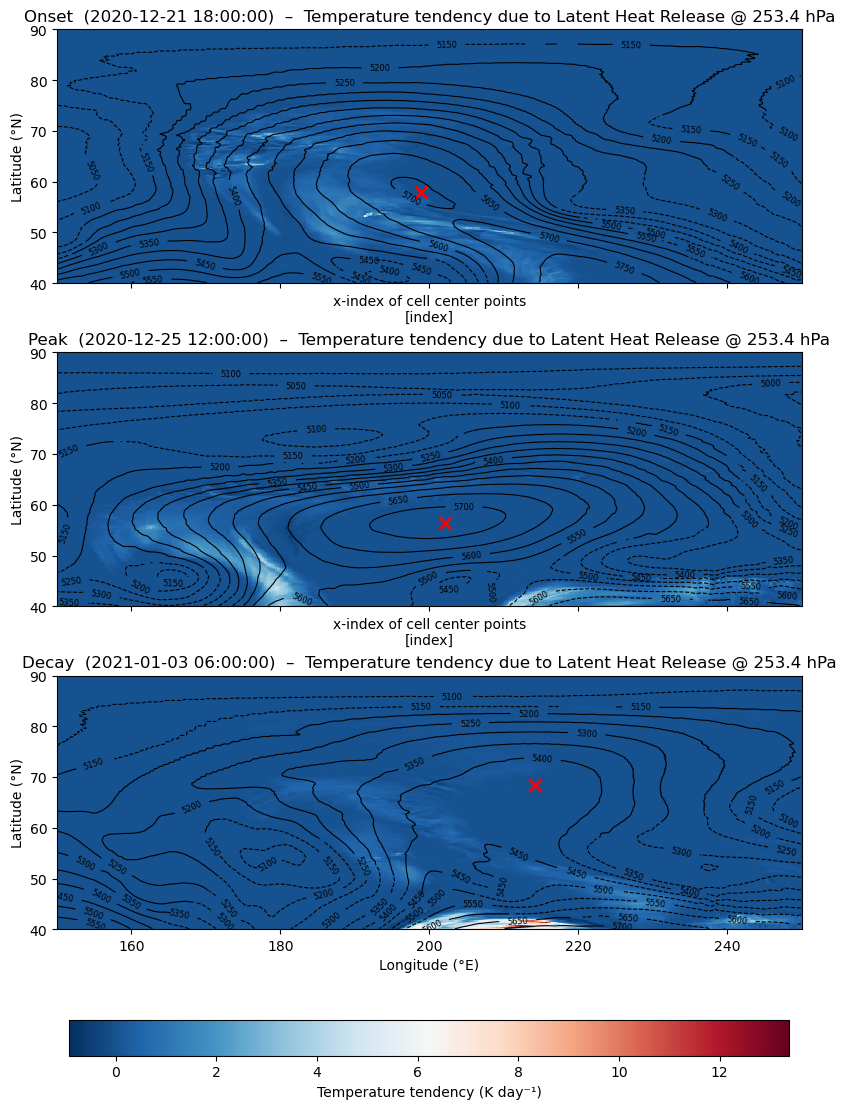

CPU times: user 15.2 s, sys: 2.99 s, total: 18.2 s
Wall time: 49 s


In [9]:
%%time
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import matplotlib.pyplot as plt

# ── 0. handy helper ─────────────────────────────────────────────────────────
def interp_slice(da, target, lev):
    """
    Average the two nearest time slices of `da` (time, pfull, y, x)
    to `target` (cftime) at the *nearest* pressure level `lev`.
    Returns (slice, true_pfull, t_before, t_after).
    """
    da_lvl    = da.sel(pfull=lev, method='nearest')
    true_lev  = float(da_lvl.pfull.item())

    times   = da_lvl.time
    t_bef   = times.where(times<=target, drop=True).max().item()
    t_aft   = times.where(times>=target, drop=True).min().item()

    slice_  = 0.5*(da_lvl.sel(time=t_bef) + da_lvl.sel(time=t_aft))
    return slice_, true_lev, t_bef, t_aft

# ── 1. parameters & region box ──────────────────────────────────────────────
TRACK_ID   = 1176
LAT_SLICE  = slice(40, 90)      # 40–90 ° N
LON_SLICE  = slice(150, 250)    # 150–250 ° E
LEV        = 500.0              # nominal hPa

# ── 2. track dataframe (already on disk) ────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df   = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')
      .query('lat.between(@LAT_SLICE.start, @LAT_SLICE.stop) '
             'and lon.between(@LON_SLICE.start, @LON_SLICE.stop)')
      .reset_index(drop=True)
)
if sub.empty:
    raise ValueError('Track 1176 has no points in the requested window.')

onset_time = sub.time.iloc[0]
decay_time = sub.time.iloc[-1]
peak_time  = sub.loc[sub['z500'].idxmax(), 'time']

def to_jul(ts: pd.Timestamp):
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_jul(v) for k, v in times_pd.items()}

print('\nSelected Gregorian → Julian:')
for k in times_pd:
    print(f"{k:>5}: {times_pd[k]}  →  {times_cf[k]}")



# ── 2.5. get lon/lat for each stage ─────────────────────────────────────────
coords = {
    'onset': (sub.loc[sub.time == onset_time, 'lon'].values[0],
              sub.loc[sub.time == onset_time, 'lat'].values[0]),
    'peak' : (sub.loc[sub.time == peak_time,  'lon'].values[0],
              sub.loc[sub.time == peak_time,  'lat'].values[0]),
    'decay': (sub.loc[sub.time == decay_time, 'lon'].values[0],
              sub.loc[sub.time == decay_time, 'lat'].values[0]),
}

# ── 3. DJF climatology of z500 (for contour styling) ────────────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
clim      = (
    z500_full
    .where(z500_full['time'].dt.season=='DJF', drop=True)
    .mean('time')
    .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
    .load()
)

# ── 4. build snapshots for each stage ───────────────────────────────────────
snaps = {}
for stage, t_cf in times_cf.items():
    # ─ temperature-tendency sum
    shallow_convection, p_lev, t_b, t_a = interp_slice(
        ds_t_dt_shallow_convection.tendency_of_air_temperature_due_to_shallow_convection_coarse, t_cf, 250
    )
    gfdl, _,     _,   _   = interp_slice(
        ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse, t_cf, 250
    )
    tend = (86400*(shallow_convection + gfdl)).sel(
        grid_yt_coarse=LAT_SLICE,
        grid_xt_coarse=LON_SLICE
    ).load()

    # ─ matching z500
    z500 = (
        z500_full
        .sel(time=t_cf, method='nearest')
        .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
        .load()
    )

    snaps[stage] = dict(tend=tend, z500=z500, true_lev=p_lev)

    print(f"{stage:>5}  bracketing: {t_b} → {t_a}  (pfull={p_lev:.1f} hPa)")

# ── 5. common colour scale for filled contours ──────────────────────────────
vmin = min(s['tend'].min().item() for s in snaps.values())
vmax = max(s['tend'].max().item() for s in snaps.values())

# ── 6. plotting ─────────────────────────────────────────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 11), sharex=True, sharey=True,
    constrained_layout=True
)
stages = ('onset', 'peak', 'decay')

for ax, st in zip(axs, stages):
    tend = snaps[st]['tend']
    z    = snaps[st]['z500']
    lev  = snaps[st]['true_lev']

    # filled field: summed tendency
    pcm = tend.plot.pcolormesh(
        ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
    )

    # mask by sign relative to climatology
    pos = z.where(z > clim)
    neg = z.where(z < clim)

    # choose sensible contour interval (50 m)
    base = 50 * round(z.mean().item()/50)
    levs = np.arange(base-400, base+401, 50)

    # solid where > climatology
    if not np.isnan(pos).all():
        cs_pos = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], pos,
            levels=levs, colors='k', linewidths=0.8, linestyles='solid'
        )
        ax.clabel(cs_pos, fmt='%d', inline=True, fontsize=6)

    # dashed where < climatology
    if not np.isnan(neg).all():
        cs_neg = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], neg,
            levels=levs, colors='k', linewidths=0.8, linestyles='dashed'
        )
        ax.clabel(cs_neg, fmt='%d', inline=True, fontsize=6)


    # add a red “×” at the track location for this stage
    lon_pt, lat_pt = coords[st]
    ax.plot(lon_pt, lat_pt,
            marker='x', color='red', markersize=8, markeredgewidth=2)

    ax.set_title(f"{st.capitalize()}  ({times_pd[st]})  –  Temperature tendency due to Latent Heat Release @ {lev:.1f} hPa")
    ax.set_ylabel('Latitude (°N)')
    # ax.set_xlim(LON_SLICE.start, LON_SLICE.stop)
    ax.set_ylim(LAT_SLICE.start, LAT_SLICE.stop)

axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.04,
             pad=0.05, label='Temperature tendency (K day⁻¹)')

plt.show()


### lower level 850 hPa


Selected Gregorian → Julian:
onset: 2020-12-21 18:00:00  →  2020-12-21 18:00:00
 peak: 2020-12-25 12:00:00  →  2020-12-25 12:00:00
decay: 2021-01-03 06:00:00  →  2021-01-03 06:00:00
onset  bracketing: 2020-12-21 16:30:00 → 2020-12-21 19:30:00  (pfull=853.8 hPa)
 peak  bracketing: 2020-12-25 10:30:00 → 2020-12-25 13:30:00  (pfull=853.8 hPa)
decay  bracketing: 2021-01-03 04:30:00 → 2021-01-03 07:30:00  (pfull=853.8 hPa)


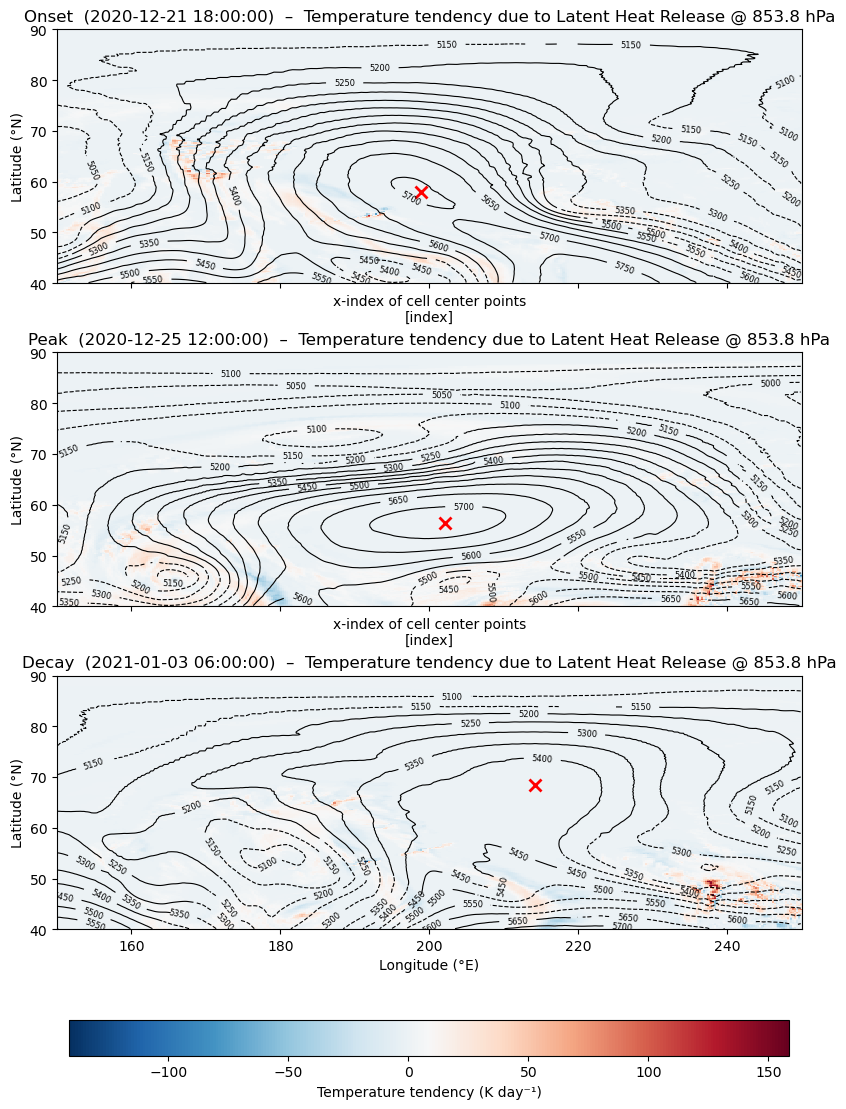

CPU times: user 15.2 s, sys: 3.14 s, total: 18.3 s
Wall time: 47.4 s


In [10]:
%%time
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import matplotlib.pyplot as plt

# ── 0. handy helper ─────────────────────────────────────────────────────────
def interp_slice(da, target, lev):
    """
    Average the two nearest time slices of `da` (time, pfull, y, x)
    to `target` (cftime) at the *nearest* pressure level `lev`.
    Returns (slice, true_pfull, t_before, t_after).
    """
    da_lvl    = da.sel(pfull=lev, method='nearest')
    true_lev  = float(da_lvl.pfull.item())

    times   = da_lvl.time
    t_bef   = times.where(times<=target, drop=True).max().item()
    t_aft   = times.where(times>=target, drop=True).min().item()

    slice_  = 0.5*(da_lvl.sel(time=t_bef) + da_lvl.sel(time=t_aft))
    return slice_, true_lev, t_bef, t_aft

# ── 1. parameters & region box ──────────────────────────────────────────────
TRACK_ID   = 1176
LAT_SLICE  = slice(40, 90)      # 40–90 ° N
LON_SLICE  = slice(150, 250)    # 150–250 ° E
LEV        = 500.0              # nominal hPa

# ── 2. track dataframe (already on disk) ────────────────────────────────────
cols = ['track_id','year','month','day','hour','i','j','lon','lat','z500']
df   = pd.read_csv(TRACK_CSV, usecols=cols)
df['time'] = pd.to_datetime(df[['year','month','day','hour']])

sub = (
    df.query('track_id == @TRACK_ID')
      .sort_values('time')
      .query('lat.between(@LAT_SLICE.start, @LAT_SLICE.stop) '
             'and lon.between(@LON_SLICE.start, @LON_SLICE.stop)')
      .reset_index(drop=True)
)
if sub.empty:
    raise ValueError('Track 1176 has no points in the requested window.')

onset_time = sub.time.iloc[0]
decay_time = sub.time.iloc[-1]
peak_time  = sub.loc[sub['z500'].idxmax(), 'time']

def to_jul(ts: pd.Timestamp):
    return cftime.DatetimeJulian(ts.year, ts.month, ts.day,
                                 ts.hour, ts.minute, ts.second,
                                 has_year_zero=False)

times_pd = {'onset': onset_time, 'peak': peak_time, 'decay': decay_time}
times_cf = {k: to_jul(v) for k, v in times_pd.items()}

print('\nSelected Gregorian → Julian:')
for k in times_pd:
    print(f"{k:>5}: {times_pd[k]}  →  {times_cf[k]}")



# ── 2.5. get lon/lat for each stage ─────────────────────────────────────────
coords = {
    'onset': (sub.loc[sub.time == onset_time, 'lon'].values[0],
              sub.loc[sub.time == onset_time, 'lat'].values[0]),
    'peak' : (sub.loc[sub.time == peak_time,  'lon'].values[0],
              sub.loc[sub.time == peak_time,  'lat'].values[0]),
    'decay': (sub.loc[sub.time == decay_time, 'lon'].values[0],
              sub.loc[sub.time == decay_time, 'lat'].values[0]),
}

# ── 3. DJF climatology of z500 (for contour styling) ────────────────────────
z500_full = ds['h_plev_coarse'].sel(plev=PLEV_VAL)
clim      = (
    z500_full
    .where(z500_full['time'].dt.season=='DJF', drop=True)
    .mean('time')
    .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
    .load()
)

# ── 4. build snapshots for each stage ───────────────────────────────────────
snaps = {}
for stage, t_cf in times_cf.items():
    # ─ temperature-tendency sum
    shallow_convection, p_lev, t_b, t_a = interp_slice(
        ds_t_dt_shallow_convection.tendency_of_air_temperature_due_to_shallow_convection_coarse, t_cf, 850
    )
    gfdl, _,     _,   _   = interp_slice(
        ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse, t_cf, 850
    )
    tend = (86400*(shallow_convection + gfdl)).sel(
        grid_yt_coarse=LAT_SLICE,
        grid_xt_coarse=LON_SLICE
    ).load()

    # ─ matching z500
    z500 = (
        z500_full
        .sel(time=t_cf, method='nearest')
        .sel(grid_yt_coarse=LAT_SLICE, grid_xt_coarse=LON_SLICE)
        .load()
    )

    snaps[stage] = dict(tend=tend, z500=z500, true_lev=p_lev)

    print(f"{stage:>5}  bracketing: {t_b} → {t_a}  (pfull={p_lev:.1f} hPa)")

# ── 5. common colour scale for filled contours ──────────────────────────────
vmin = min(s['tend'].min().item() for s in snaps.values())
vmax = max(s['tend'].max().item() for s in snaps.values())

# ── 6. plotting ─────────────────────────────────────────────────────────────
fig, axs = plt.subplots(
    nrows=3, figsize=(8, 11), sharex=True, sharey=True,
    constrained_layout=True
)
stages = ('onset', 'peak', 'decay')

for ax, st in zip(axs, stages):
    tend = snaps[st]['tend']
    z    = snaps[st]['z500']
    lev  = snaps[st]['true_lev']

    # filled field: summed tendency
    pcm = tend.plot.pcolormesh(
        ax=ax, cmap='RdBu_r', vmin=vmin, vmax=vmax, add_colorbar=False
    )

    # mask by sign relative to climatology
    pos = z.where(z > clim)
    neg = z.where(z < clim)

    # choose sensible contour interval (50 m)
    base = 50 * round(z.mean().item()/50)
    levs = np.arange(base-400, base+401, 50)

    # solid where > climatology
    if not np.isnan(pos).all():
        cs_pos = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], pos,
            levels=levs, colors='k', linewidths=0.8, linestyles='solid'
        )
        ax.clabel(cs_pos, fmt='%d', inline=True, fontsize=6)

    # dashed where < climatology
    if not np.isnan(neg).all():
        cs_neg = ax.contour(
            z['grid_xt_coarse'], z['grid_yt_coarse'], neg,
            levels=levs, colors='k', linewidths=0.8, linestyles='dashed'
        )
        ax.clabel(cs_neg, fmt='%d', inline=True, fontsize=6)


    # add a red “×” at the track location for this stage
    lon_pt, lat_pt = coords[st]
    ax.plot(lon_pt, lat_pt,
            marker='x', color='red', markersize=8, markeredgewidth=2)

    ax.set_title(f"{st.capitalize()}  ({times_pd[st]})  –  Temperature tendency due to Latent Heat Release @ {lev:.1f} hPa")
    ax.set_ylabel('Latitude (°N)')
    # ax.set_xlim(LON_SLICE.start, LON_SLICE.stop)
    ax.set_ylim(LAT_SLICE.start, LAT_SLICE.stop)

axs[-1].set_xlabel('Longitude (°E)')
fig.colorbar(pcm, ax=axs, orientation='horizontal', fraction=0.04,
             pad=0.05, label='Temperature tendency (K day⁻¹)')

plt.show()


$$
\frac{D q}{D t} \approx -g\left(\frac{p_s}{p}\right)^{\frac{R}{c_p}}\left[\left(\frac{\partial w}{\partial y}-\frac{\partial v}{\partial p}\right) \frac{\partial \dot{T}}{\partial x}+\left(\frac{\partial u}{\partial p}-\frac{\partial w}{\partial x}\right) \frac{\partial \dot{T}}{\partial y}+\left(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}+f\right) \frac{\partial \dot{T}}{\partial p}\right]\approx -g\left(\frac{p_s}{p}\right)^{\frac{R}{c_p}}\left[\left(\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}+f\right) \frac{\partial \dot{T}}{\partial p}\right]
$$

$$
\left.\frac{D q}{D t}\right|_{\dot{T}}=-g\left(\frac{p_*}{p}\right)^{R / c_p}(\zeta+f) \frac{\partial \dot{T}}{\partial p}, \quad \zeta=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y} .
$$

In [ ]:
ds_t_dt = ds_t_dt_phys+ds_t_dt_gfdlmp


In [62]:
import xarray as xr
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import intake,yaml,os
import intake_esm

# result of build_xshield_cat.ipynb
col_url = "/home/tmerlis/hackathon/catbuild/xsh24_cat.json"
col = intake.open_esm_datastore(col_url)

cat_vort_plev = col.search(variable_id = 'vort_plev_coarse_C3072_1440x720')
dset_dict_vort_plev = cat_vort_plev.to_dataset_dict(cdf_kwargs={'chunks': {'time':5}, 'decode_times': True})
ds_vort_plev = dset_dict_vort_plev['20191020.00Z.C3072.xs24v2.GLOBALFV3']





--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.member_id'


In [61]:
# ---------------------------------------------------------------------
#  0. constants
# ---------------------------------------------------------------------
g     = 9.80665                  # m s⁻²
R     = 287.0                    # J kg⁻¹ K⁻¹   (dry-air gas constant)
c_p   = 1004.0                   # J kg⁻¹ K⁻¹
Ω     = 7.292115e-5              # s⁻¹          (Earth’s rotation)

# ---------------------------------------------------------------------
#  1. the diabatic-heating tendency  ẊT = Σ t_dt               (K s⁻¹)
# ---------------------------------------------------------------------
dotT = (ds_t_dt_phys.t_dt_phys_coarse + ds_t_dt_gfdlmp.t_dt_gfdlmp_coarse)\
         .chunk({'time':5, 'pfull':16, 'grid_yt_coarse':144})

# ---------------------------------------------------------------------
#  2. vertical derivative  ∂ẊT/∂p  (K s⁻¹ Pa⁻¹)
#     – work in Pa for a correct metric derivative
# ---------------------------------------------------------------------
p_hPa = ds_t_dt_phys.pfull                 # 4.5 … 998   (hPa)
p_Pa  = p_hPa * 100.0            # same values but in Pa
dotT  = dotT.assign_coords(pPa=('pfull', p_Pa)).swap_dims({'pfull':'pPa'})

dotT_dp = dotT.differentiate('pPa')

# ---------------------------------------------------------------------
#  3. (ζ+f) on the same grid
# ---------------------------------------------------------------------
ζ = ds_vort_plev.vort_plev_coarse.chunk({'time':5, 'pfull':16, 'grid_yt_coarse':144})

lat_rad = np.deg2rad(ds.grid_yt_coarse)
f = (2*Ω*np.sin(lat_rad)).broadcast_like(ζ)

ζ_plus_f = (ζ + f)

# ---------------------------------------------------------------------
#  4. the (ps/p)^{R/cp} conversion factor
#     – p_s already coarse-grained to the 1/4-deg grid
# ---------------------------------------------------------------------
ps     = ds.psl_coarse  # time, lat, lon    (Pa)
ps     = ps.chunk({'time':5, 'grid_yt_coarse':144})

# broadcast p into a 3-D field that matches dotT_dp
p3d = xr.DataArray(
        p_Pa.values,
        dims   = ['pPa'],
        coords = {'pPa':p_Pa},
     ).broadcast_like(dotT_dp)

scale = (ps / p3d) ** (R / c_p)

# ---------------------------------------------------------------------
#  5. assemble the PV-tendency term  (s⁻²)
# ---------------------------------------------------------------------
pv_tend_dotT = -g * scale * ζ_plus_f * dotT_dp
pv_tend_dotT.name = 'pv_tend_from_diabatic_heating'
pv_tend_dotT.attrs['long_name'] = (
    'PV-tendency contribution from diabatic heating, '
    '−g (ps/p)^{R/cp}(ζ+f)∂ẊT/∂p'
)
pv_tend_dotT.attrs['units'] = 's⁻²'

# ---------------------------------------------------------------------
#  6. persist or write out as needed
# ---------------------------------------------------------------------
pv_tend_dotT = pv_tend_dotT.persist()        # keeps memory ≤ 40 GB
# pv_tend_dotT.to_netcdf('pv_tendency_dotT.nc')


TypeError: Variable 'pPa': Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.